In [44]:
import geopandas as gpd
import lxml
import missingno as msno
import numpy as np
import pandas as pd
from shapely.geometry import Point

from urbana.constants import DIR_DATA, DIR_REPO
from urbana.data.datasets import merge_datasets
from urbana.data.geo import harversine_distance_btw_geoseries_point

SCL_PATH = DIR_DATA / "external" / "scl"
CENSUS_PATH = SCL_PATH / "census"
URBAN_AREAS_PATH = SCL_PATH / "urban_areas"
PATH_R13 = SCL_PATH /  "R13"

<AxesSubplot: >

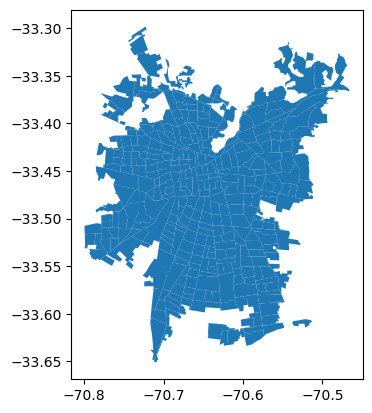

In [45]:
urban_districts = gpd.read_file(SCL_PATH / 'urban_districts')
urban_districts.plot()

In [46]:
OSM_PATH = SCL_PATH / "OSM"

osm_clipped_file = OSM_PATH / 'clipped-scl-osm.pbf'

if not osm_clipped_file.exists():
    import os
    bounds = urban_districts.total_bounds
    print(bounds)
    print(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
    os.system(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
else:
    print('data already available :D')

import pyrosm
osm = pyrosm.OSM(str(osm_clipped_file))
scl_pois = osm.get_pois().to_crs(urban_districts.crs)
scl_pois = scl_pois[~(scl_pois["lat"].isna() | scl_pois["lon"].isna())] # eliminamos aquellos que no tienen lat y/o lon

data already available :D


In [ ]:
census = (pd.read_csv(CENSUS_PATH / 'Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv(CENSUS_PATH / 'Censo2017_Identificación_Geográfica' / 'Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)

census["POBLACION"] = census["HOMBRES"] + census["MUJERES"]

dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

In [ ]:
sect = urban_districts.merge(dc_values, how='inner')
print(sect.shape)
sect.head()

(342, 16)


,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",7140,8978,1021,1562,10831,2466,1487
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",8120,9040,936,2489,12392,884,1632
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",6705,7886,616,1412,9940,2337,1180
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",6576,7747,949,999,9862,2195,1632
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",9076,10521,1033,1236,13872,2966,2716


In [ ]:
SANTIAGO_CENTRO = Point(-33.45, -70.666666666667)
d_haversine = harversine_distance_btw_geoseries_point(
    sect["geometry"].centroid, SANTIAGO_CENTRO
).to_frame("Distance_Center")
sect = merge_datasets(sect, d_haversine)
sect

/tmp/ipykernel_12356/502574414.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sect["geometry"].centroid, SANTIAGO_CENTRO


,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES,Distance_Center
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",7140,8978,1021,1562,10831,2466,1487,4702.473475
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",8120,9040,936,2489,12392,884,1632,4700.800297
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",6705,7886,616,1412,9940,2337,1180,4700.952628
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",6576,7747,949,999,9862,2195,1632,4701.934505
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",9076,10521,1033,1236,13872,2966,2716,4701.089852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,13,134,13401,7,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,MAESTRANZA,"MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...",5663,6018,1091,1682,8210,468,165,4683.252450
338,13,134,13401,14,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,LOS MORROS,"POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...",14587,15143,2906,4436,19995,1702,501,4681.289241
339,13,133,13301,3,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,COLINA,ALGARROBAL,"POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...",6735,6618,1305,2070,8871,696,1137,4716.295864
340,13,133,13302,4,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,LAMPA,LA VILANA,"POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...",32895,32577,7632,8898,44553,1758,2757,4715.019557


In [ ]:
print(scl_pois.columns[2:])
# scl_pois = scl_pois.drop(['gambling', 'cafe'], axis=1)
scl_pois.sample(5)
scl_pois['museum'].value_counts()

Index(['timestamp', 'lat', 'id', 'lon', 'tags', 'version', 'addr:city',
       'addr:country', 'addr:full', 'addr:housenumber', 'addr:housename',
       'addr:postcode', 'addr:place', 'addr:street', 'email', 'name',
       'opening_hours', 'operator', 'phone', 'ref', 'website', 'amenity',
       'atm', 'bicycle_parking', 'bicycle_rental', 'bar', 'building',
       'building:levels', 'drinking_water', 'fast_food', 'fountain',
       'gambling', 'internet_access', 'landuse', 'office', 'parking',
       'social_facility', 'source', 'start_date', 'wikipedia', 'bicycle',
       'clothes', 'craft', 'organic', 'pastry', 'religion', 'second_hand',
       'shoes', 'shop', 'trade', 'wholesale', 'attraction', 'guest_house',
       'information', 'museum', 'tourism', 'zoo', 'geometry', 'osm_type',
       'cafe', 'police', 'school', 'water'],
      dtype='object')


art           8
history       7
open_air      2
person        1
children      1
technology    1
science       1
Name: museum, dtype: int64

In [ ]:
count_columns = ['religion', 'shop', 'tourism', 'museum']
pois_with_districts = gpd.sjoin(urban_districts, scl_pois)
for c in count_columns:
    pois_with_districts[c] = pois_with_districts[c].apply(lambda x: 0 if x == None else 1)
# print(pois_with_districts)
pois_counted = pois_with_districts.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'COD_DISTRI'])[count_columns].sum().reset_index().drop(['REGION', 'PROVINCIA', 'COMUNA', 'COD_DISTRI'], axis=1)

sect = merge_datasets(sect, pois_counted)

In [ ]:
sect

,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,HOMBRES,...,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES,Distance_Center,religion,shop,tourism,museum
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",7140,...,1021,1562,10831,2466,1487,4702.473475,0.0,80.0,78.0,4.0
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",8120,...,936,2489,12392,884,1632,4700.800297,0.0,316.0,47.0,5.0
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",6705,...,616,1412,9940,2337,1180,4700.952628,0.0,54.0,8.0,0.0
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",6576,...,949,999,9862,2195,1632,4701.934505,1.0,58.0,15.0,0.0
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",9076,...,1033,1236,13872,2966,2716,4701.089852,1.0,47.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,13,134,13401,7,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,MAESTRANZA,"MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...",5663,...,1091,1682,8210,468,165,4683.252450,0.0,1.0,0.0,0.0
338,13,134,13401,14,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,LOS MORROS,"POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...",14587,...,2906,4436,19995,1702,501,4681.289241,1.0,0.0,0.0,0.0
339,13,133,13301,3,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,COLINA,ALGARROBAL,"POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...",6735,...,1305,2070,8871,696,1137,4716.295864,0.0,1.0,0.0,0.0
340,13,133,13302,4,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,LAMPA,LA VILANA,"POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...",32895,...,7632,8898,44553,1758,2757,4715.019557,NaN,NaN,NaN,NaN


<AxesSubplot: >

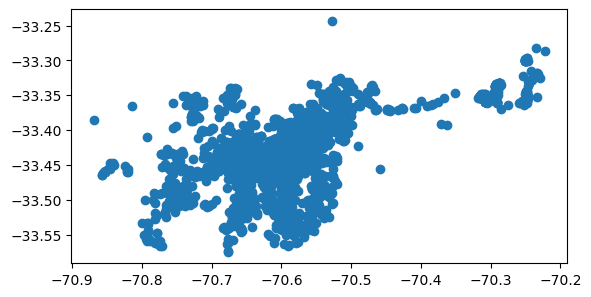

In [ ]:
inside_airbnb = (
    pd.read_csv(SCL_PATH / "29-03-2023-insideAirBnB.csv")
)
inside_airbnb["price"] = inside_airbnb["price"].apply(lambda x: int(x[1:-3].replace(",", '')))
inside_airbnb["per_person_price"] = inside_airbnb["price"].div(inside_airbnb["accommodates"])
inside_airbnb["rating"] = inside_airbnb["review_scores_location"].astype("float")
# inside_airbnb["rating"]
gdf = gpd.GeoDataFrame(
    data=inside_airbnb.drop(
        list(inside_airbnb.columns[
            (inside_airbnb.columns.str.contains("host|availability|url|nights|calendar|scrap|description|neighbourhood|book|bath|amenities|license|review"))
            ]), axis=1), 
                       geometry=gpd.points_from_xy(inside_airbnb['longitude'], inside_airbnb["latitude"]))
gdf.plot()

In [ ]:
# tagging by section
# Set the column for the tags
gdf["Tag"] = -1

# Classify the Airbnbs based on their location
for i in range(len(sect.index)):
    selection = gdf["geometry"].within(sect["geometry"][i])
    selection_index = selection[selection].index
    gdf.loc[selection_index, "Tag"] = sect.index[i]

#removing out of zone airbnbs
gdf = gdf[gdf["Tag"] != -1]     

counts = (
    gdf["Tag"].value_counts().rename("Airbnb_Count").sort_index().to_frame()
)


prices = (
    gdf.groupby(["Tag"])["price"].agg("mean").rename("Airbnb_Price").sort_index()
).to_frame()

per_person_prices = (
    gdf.groupby(["Tag"])["per_person_price"]
    .agg("mean")
    .rename("Airbnb_Per_Person_Price")
    .sort_index()
).to_frame()

ratings = (
    gdf.groupby(["Tag"])["rating"]
    .agg("mean")
    .rename("Airbnb_Location_Rating")
    .sort_index()
).to_frame()

sect = merge_datasets(sect, counts)
sect = merge_datasets(sect, prices)
sect = merge_datasets(sect, per_person_prices)
sect = merge_datasets(sect, ratings)

# Saving the data

     REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
337      13        134   13401           7  REGIÓN METROPOLITANA DE SANTIAGO   
338      13        134   13401          14  REGIÓN METROPOLITANA DE SANTIAGO   
339      13        133   13301           3  REGIÓN METROPOLITANA DE SANTIAGO   
340      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
341      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI    DESC_COMUN           

<AxesSubplot: >

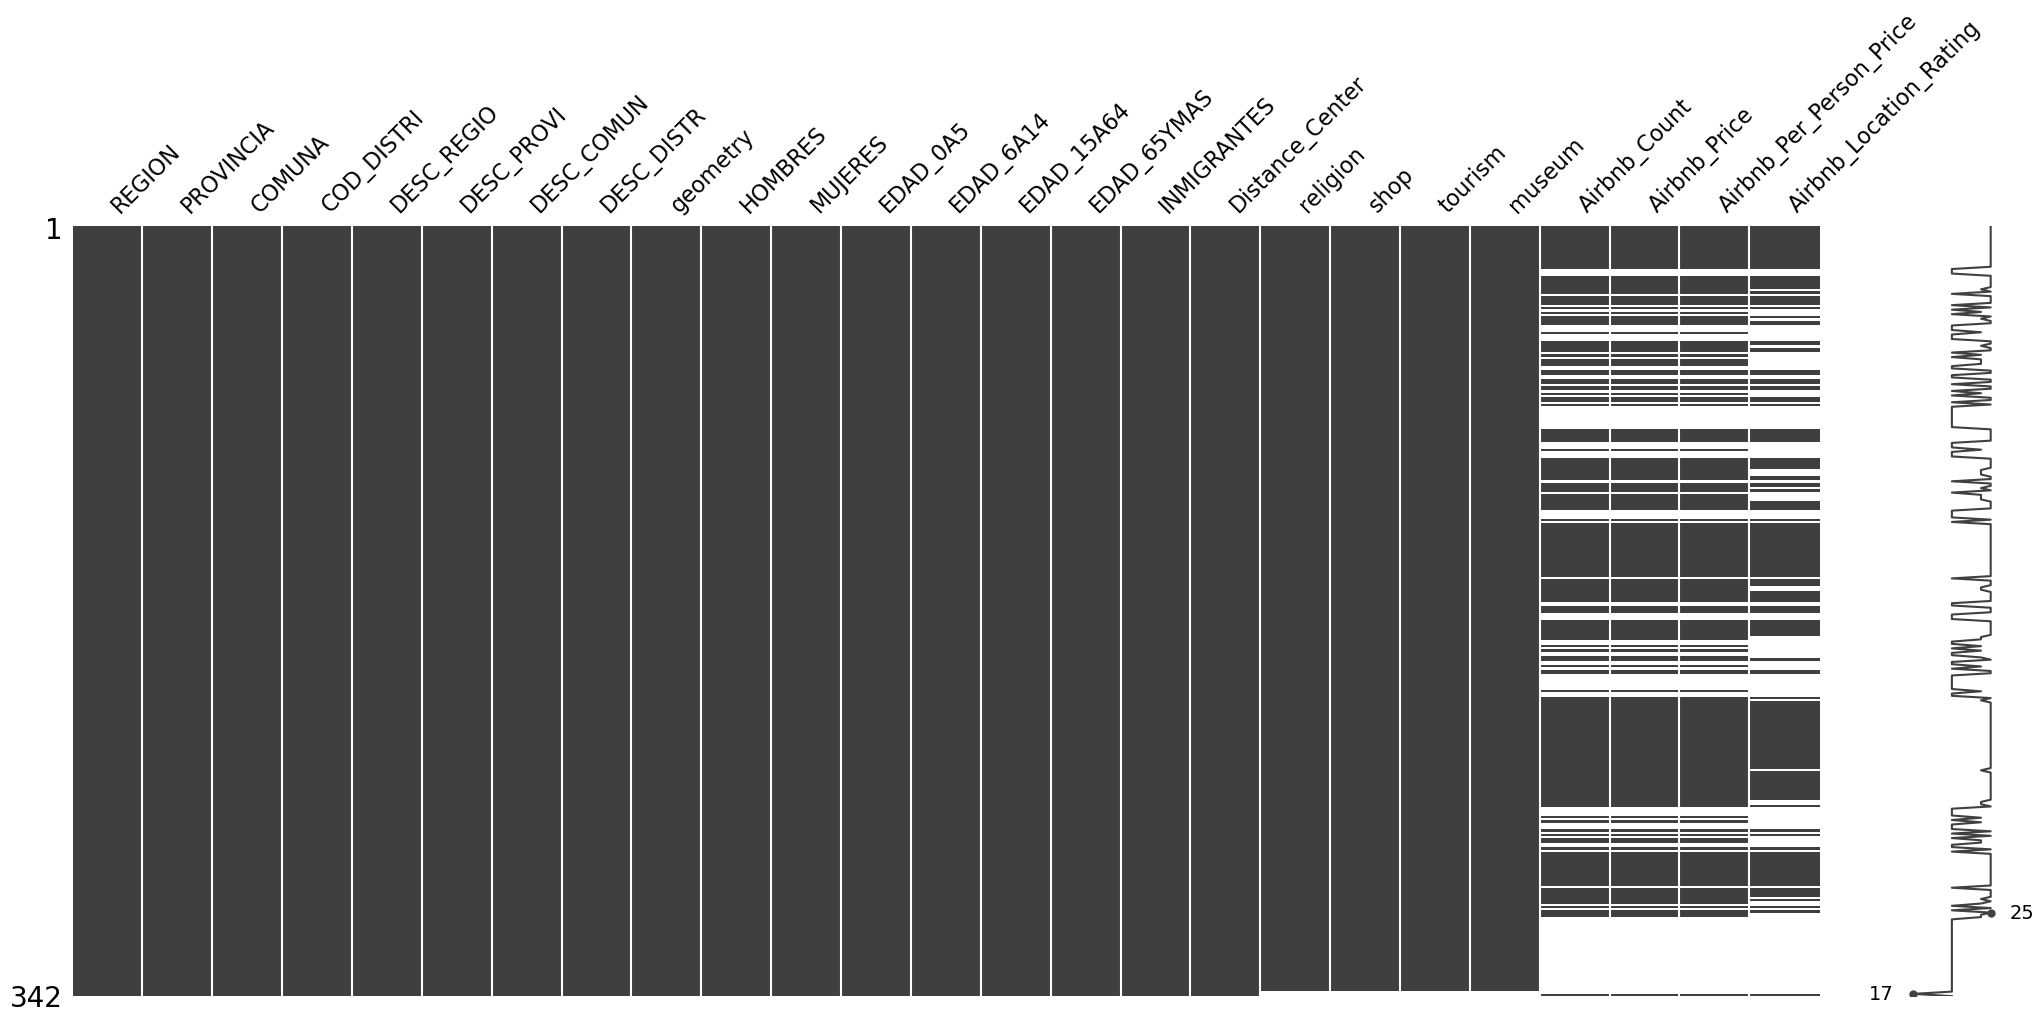

In [ ]:
# print(sect)
msno.matrix(sect)

In [ ]:
OUTPUT_PATH = SCL_PATH / "output"
sect.to_csv(OUTPUT_PATH / "census_processed.csv")